In [0]:
!pip install plotly_express

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
import plotly_express as px

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
url = 'https://raw.githubusercontent.com/Nolanole/NFL-Weather-Project/master/QB_weather_cleaned.csv'
df = pd.read_csv(url).drop(columns=['Unnamed: 0', 'week', 'game_id'])

In [0]:
#more cleaning: fillna for fumbles: -- = 0
df.fumbles.fillna(0, inplace=True)
df.fumbles_lost.fillna(0, inplace=True)

#rename a few columns:
col_mapper = {'avg_dewpoint':'dewpoint', 'avg_humidity':'humidity', 'avg_temp':'temp', 'avg_wind':'wind'}
df = df.rename(columns=col_mapper)

#stadium cleaning:
stadium_mapper = {'Solider Field': 'Soldier Field', 'Cleveland Browns Stadium': 'Cleveland Stadium',
                  'Busch Memorial Stadium':'Busch Stadium', 'Dolphins Stadium': 'Dolphin Stadium',
                  'O.o Coliseum':'Oakland-Alameda County Coliseum','Oakland Coliseum':'Oakland-Alameda County Coliseum', 
                  'O.co Coliseum': 'Oakland-Alameda County Coliseum'}

df['stadium'] = df.stadium.replace(stadium_mapper)

In [0]:
#recast column types:

#date:

df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

#ints

int_cols = ['dome', 'fog_or_haze', 'fumbles', 'ints', 'pass_attempts', 
            'pass_completions', 'sacks', 'tds', 'yards', 'dome', 'fumbles_lost']

for col in int_cols:
  df[col] = df[col].astype('int64')

#categoricals: precipitation, sky, fog_haze? 

cat_cols = ['precipitation', 'sky', 'fog_or_haze', 'dome']
for col in cat_cols:
  df[col] = df[col].astype('category')

In [0]:
'''In the late stages of my analyisis, I discovered that some data for certain 
quarterbacks was missing from earlier dataset, which resulted in only part of 
a teams passing statistics being compiled for abt 1-3% of the games. To rectify, 
Ive decided to drop all games wher a team attempted fewer than 10 passes. I know 
that some of this is accurate outlier data, but I estimate the number of incorect 
data points far outnumbers the number of true outliers. I believe that the overall
gist of the analysis is reasonably accurate. I also decided to only include data 
from 1985 instead of 1980'''

df = df[(df.pass_attempts>9) & (df.date > '1984-03-01')]

In [0]:
#combine points scored and divide/2 as avg pts per team in that game, 
#add column for fantasy points scored, and drop the other score cols:
for i in df.index:
  df.at[i, 'points'] = (df.at[i, 'score_home'] + df.at[i, 'score_away'])/2
  df.at[i, 'mistakes'] = df.at[i, 'ints'] + df.at[i, 'fumbles'] + df.at[i, 'sacks']
  df.at[i, 'turnovers'] = df.at[i, 'ints'] + df.at[i, 'fumbles_lost']
  df.at[i, 'fpts'] = df.at[i, 'yards']/25 + df.at[i, 'tds']*4 - df.at[i, 'turnovers']*2
  
  
drop_cols = ['score_away', 'score_home', 'score']
df.drop(drop_cols, axis='columns', inplace=True)

In [0]:
#List some columns together by stat category:

efficiency_cols = ['ypa', 'comp_percent', 'rating']

production_cols = ['yards', 'tds', 'fpts']

bad_play_cols = ['sacks', 'fumbles', 'ints']


In [0]:
#Bin some of the data

temp_bins = [-5,15,25,35,45,55,65,75,85,95,105]

df['Temperature Ranges'] = pd.cut(df.temp, bins=temp_bins, duplicates='drop')

df['points_bins'] = pd.qcut(df.points, 4)

df['wind_bins'] = pd.cut(df.wind, bins=[-0.1,10,15,20,41])

df['year_bins'] = pd.qcut(df.date, 4)


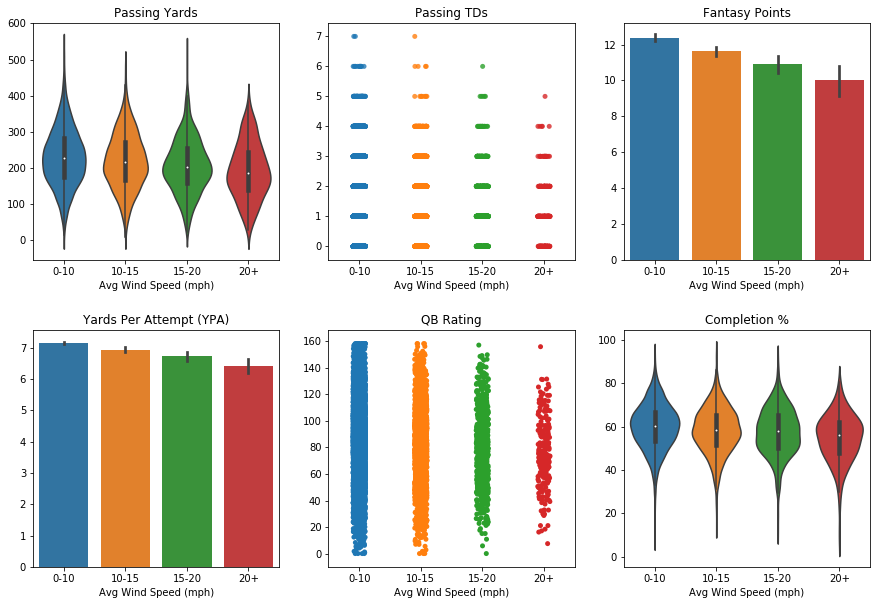

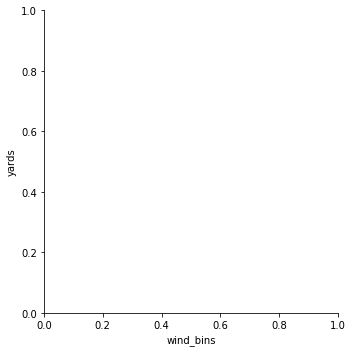

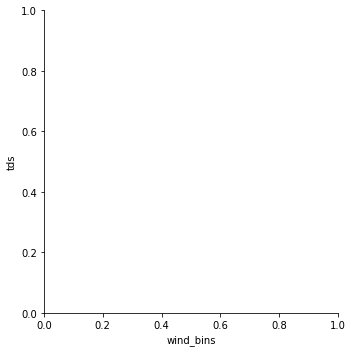

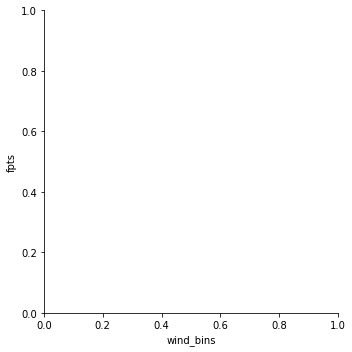

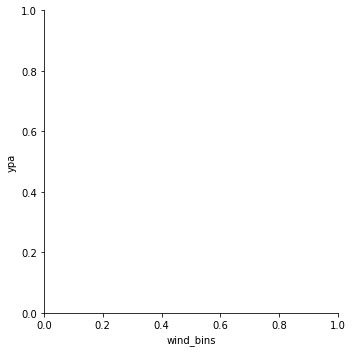

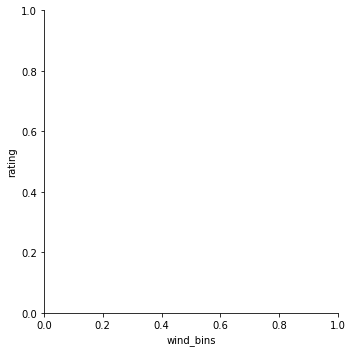

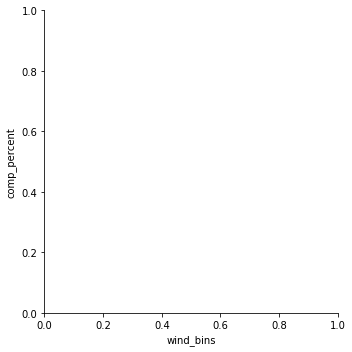

In [60]:
xtick_labels = ['0-10', '10-15', '15-20', '20+']

fig, ax = plt.subplots(figsize=(15,10), ncols=3, nrows=2)
plt.subplots_adjust(hspace=.3)

p1 = sns.catplot('wind_bins', 'yards', data=df, kind='violin', ci='sd', alpha=0.8, ax=ax[0][0])
ax[0][0].set_ylabel('')
ax[0][0].set_title('Passing Yards')
ax[0][0].set_xlabel('Avg Wind Speed (mph)')
ax[0][0].set_xticklabels(xtick_labels)
p2 = sns.catplot('wind_bins', 'tds', data=df, kind='strip', alpha=.8, ax=ax[0][1])
ax[0][1].set_ylabel('')
ax[0][1].set_title('Passing TDs')
ax[0][1].set_xlabel('Avg Wind Speed (mph)')
ax[0][1].set_xticklabels(xtick_labels)
p3 = sns.catplot('wind_bins', 'fpts', data=df, kind='bar', ax=ax[0][2])
ax[0][2].set_ylabel('')
ax[0][2].set_title('Fantasy Points')
ax[0][2].set_xlabel('Avg Wind Speed (mph)')
ax[0][2].set_xticklabels(xtick_labels)
p4 = sns.catplot('wind_bins', 'ypa', data=df, kind='bar', ax=ax[1][0])
ax[1][0].set_ylabel('')
ax[1][0].set_title('Yards Per Attempt (YPA)')
ax[1][0].set_xlabel('Avg Wind Speed (mph)')
ax[1][0].set_xticklabels(xtick_labels)
p5 = sns.catplot('wind_bins', 'rating', data=df, kind='strip', ci='sd', ax=ax[1][1])
ax[1][1].set_ylabel('')
ax[1][1].set_title('QB Rating')
ax[1][1].set_xlabel('Avg Wind Speed (mph)')
ax[1][1].set_xticklabels(xtick_labels)
p6 = sns.catplot('wind_bins', 'comp_percent', data=df, kind='violin', ci='sd', alpha=0.6, ax=ax[1][2])
ax[1][2].set_ylabel('')
ax[1][2].set_title('Completion %')
ax[1][2].set_xlabel('Avg Wind Speed (mph)')
ax[1][2].set_xticklabels(xtick_labels)



plt.show()

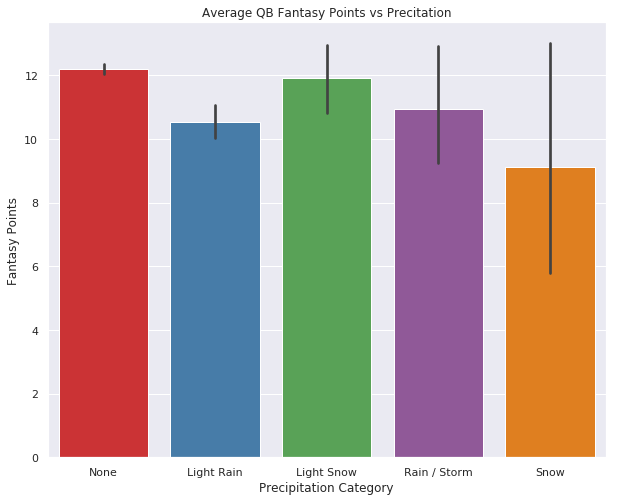

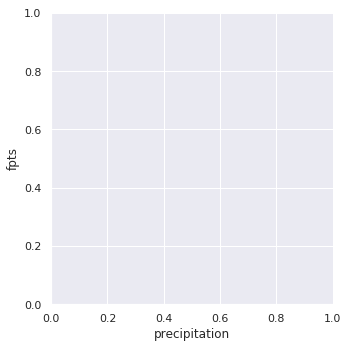

In [126]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_palette(palette='Set1', n_colors=5)
sns.catplot('precipitation', 'fpts', data=df, kind='bar',ax=ax)
ax.set_ylabel('Fantasy Points')
ax.set_xlabel('Precipitation Category')
ax.set_xticklabels(['None', 'Light Rain', 'Light Snow', 'Rain / Storm', 'Snow'])
ax.set_title('Average QB Fantasy Points vs Precitation')
plt.show()

Text(0.5, 1.0, 'Game Temperature Ranges and QB Fantasy Points Scored')

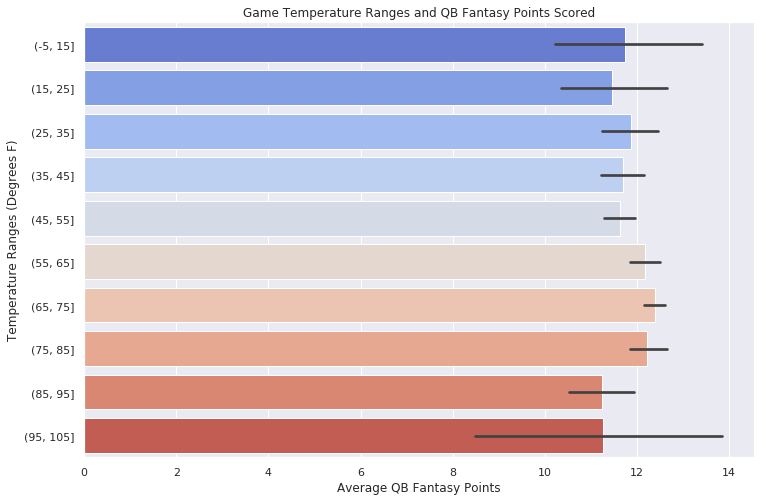

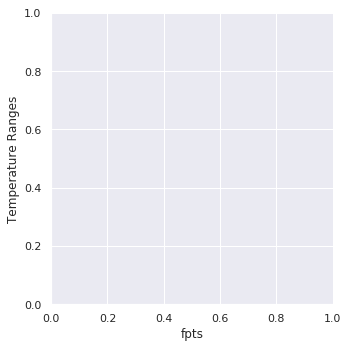

In [116]:
fig, ax = plt.subplots(figsize= (12,8))
sns.set_palette(palette='coolwarm', n_colors=10)
sns.catplot('fpts','Temperature Ranges', data=df, kind='bar', orient='h', ax=ax)
ax.set_ylabel('Temperature Ranges (Degrees F)')
ax.set_xlabel('Average QB Fantasy Points')
ax.set_title('Game Temperature Ranges and QB Fantasy Points Scored')


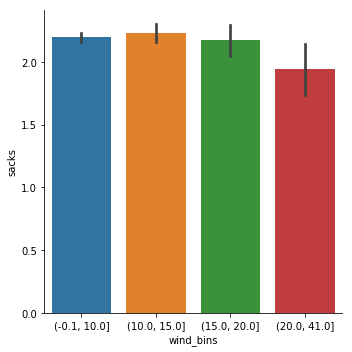

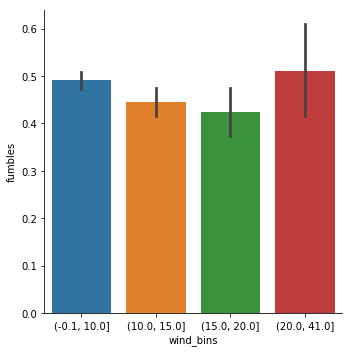

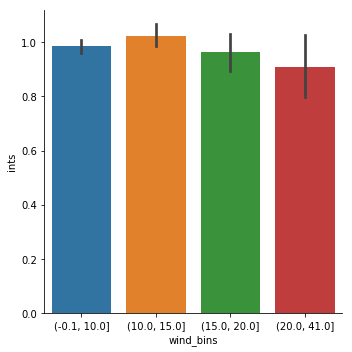

In [0]:
for col in bad_play_cols:
  sns.catplot('wind_bins', col, data=df, kind='bar')#, alpha=0.5)

In [147]:
configure_plotly_browser_state()
px.scatter(df, x="wind", y="fpts", color="precipitation", size='max_windgust',
           log_x=False, size_max=20, hover_name="sky", labels=dict(precipitation='Precipitation', 
           fpts='Fantasy Points', wind='Game AvG Windspeed in mph (size = max Wind Gust)'), 
           title='.                                                       QB Fantasy Points Affected by Wind and Precipitation                             ')

In [152]:
configure_plotly_browser_state()
px.scatter(df, x="wind", y="fpts", color="precipitation", size='turnovers',
           log_x=False, size_max=20, facet_col="sky", labels=dict(fpts='Fantasy Points', wind='Game AVG Windspeed in mph (size = max Wind Gust)'), 
           title='.                                                       QB Fantasy Points Across SkyCover categories, Wind, and Precipitation                             ')

In [137]:
configure_plotly_browser_state()
px.scatter(df, x="wind", y="fpts", color="temp", size="max_windgust", 
           facet_col='precipitation', log_x=False, size_max=20, hover_name="sky",
           title=' .                                   QB Fantasy Points Across Precipitation Categories and Wind Speeds and Temperatures', 
           labels=dict(fpts='Fantasy Points', wind='Wind (mph)', temp='Temperature', precipitation=' '))

In [0]:
#10 teams whose stadiums avg coldest temp: 
coldest_stadiums = df[df.stadium.isin(df.groupby('stadium').temp.mean().sort_values()[:10].index)]

#10 hottest:
hottest_stadiums = df[df.stadium.isin(df.groupby('stadium').temp.mean().sort_values(ascending=False)[:10].index)]

#10 windiest:
windiest_stadiums = df[df.stadium.isin(df.groupby('stadium').wind.mean().sort_values(ascending=False)[:10].index)]

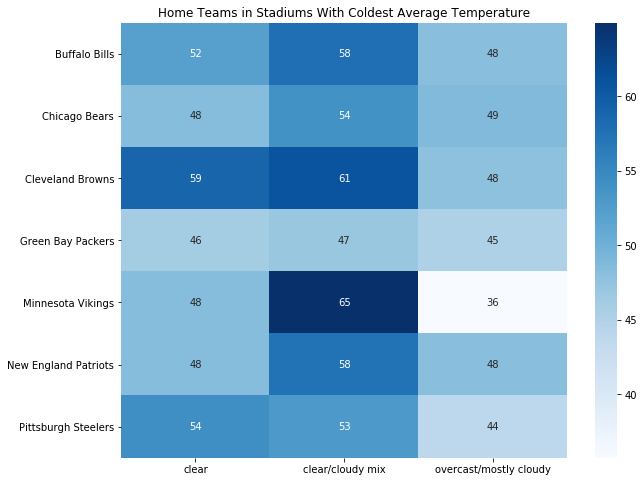

In [0]:
#Coldest stadiums heatmap (change the colors to blues:
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Home Teams in Stadiums With Coldest Average Temperature')
ax.yaxis.label.set_visible(False)
ax.xaxis.label.set_visible(False)
sns.heatmap(coldest_stadiums.pivot_table(values='temp', index='home', columns='sky', aggfunc='mean'), cmap="Blues", annot=True)


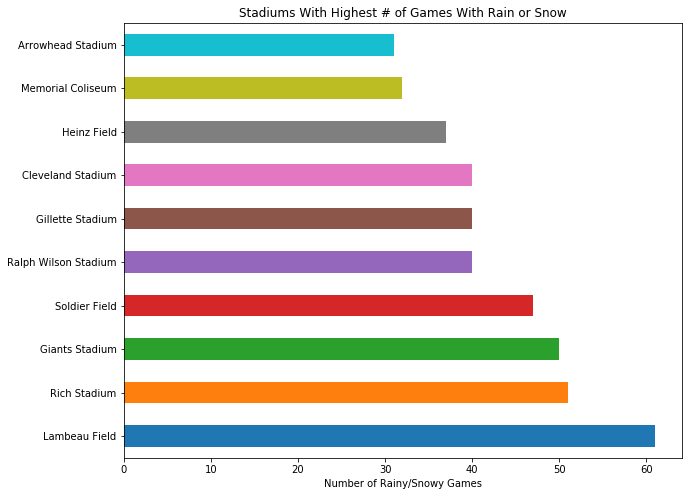

In [0]:
#top 10 Most Rain or Snow Games:
rainiest_stadiums = df[df.precipitation != 'None'].groupby('stadium').precipitation.count().sort_values(ascending = False)[:10]


#Annotated Hbar chart for this:
fig, ax = plt.subplots(figsize=(10,8))
rainiest_stadiums.plot(kind='barh')
plt.title('Stadiums With Highest # of Games With Rain or Snow')
plt.xlabel('Number of Rainy/Snowy Games')
ax.yaxis.label.set_visible(False)
plt.show()

In [0]:
#split df into 2 groups: great weather(including dome), vs bad weather
#great weather defined as wind under 5mph, temp bw 60-80, clear sky and no precipitation:

great_condition = (df.dome == 1) | (df.wind < 5) & (df.temp > 60) & (df.temp < 80) & (df.precipitation=='None') & (df.sky == 'clear')
great = df[great_condition].reset_index(drop=True)

#bad weather defined as wind under 5mph, temp below 10 or above 95, and rain/storm (not light)
bad_condition = (df.precipitation == 'rain/storm') | (df.precipitation == 'snow') | (df.wind > 12) | (df.temp < 10) | (df.temp > 95)
bad = df[bad_condition].reset_index(drop=True)
  

In [0]:
#get player counts in great and bad dfs, limit to players who appear at least 10 times in both

great_pc = great.name.value_counts()
bad_pc = bad.name.value_counts()

#limit to 10+
great_pc = great_pc[great_pc >= 10]
bad_pc = bad_pc[bad_pc >= 10]

#list of players who appear in both:
players_in_both = list(df[(df.name.isin(great_pc.index)) & (df.name.isin(bad_pc.index))].name.value_counts().index)


In [0]:
#new df comparing player performance in bad vs good:

stat_cols = efficiency_cols + production_cols + bad_play_cols + ['name']

difference_df = pd.DataFrame(data=None, columns = stat_cols)

row_list = []
for name in players_in_both:
  row = pd.Series(data=None)
  row['name'] = name
  for col in stat_cols:
    if col == 'name':
      continue
    great_agg = great[great.name==name][col].mean()
    bad_agg = bad[bad.name==name][col].mean()
    difference = bad_agg - great_agg
    #A handful of players have no fumble data recorded, so this is to handle zero division error:
    try:
      percent_diff = difference / great_agg
    except:
      percent_diff = 0
    row['great_' + col + '_avg'] = great_agg
    row['bad_' + col + '_avg'] = bad_agg
    row[col + '_diff'] = difference
    row[col + '_percent_diff'] = percent_diff*100
  row_list.append(row)

difference_df = pd.DataFrame(data=row_list)
difference_df['avg_production_diff'] = (difference_df['yards_percent_diff'] + difference_df['tds_percent_diff'] + difference_df['fpts_percent_diff']) / 3
difference_df['avg_efficiency_diff'] = (difference_df['ypa_percent_diff'] + difference_df['rating_percent_diff'] + difference_df['comp_percent_percent_diff']) / 3
difference_df['avg_turnovers_diff'] = (difference_df['fumbles_percent_diff'] + difference_df['ints_percent_diff']) / 2

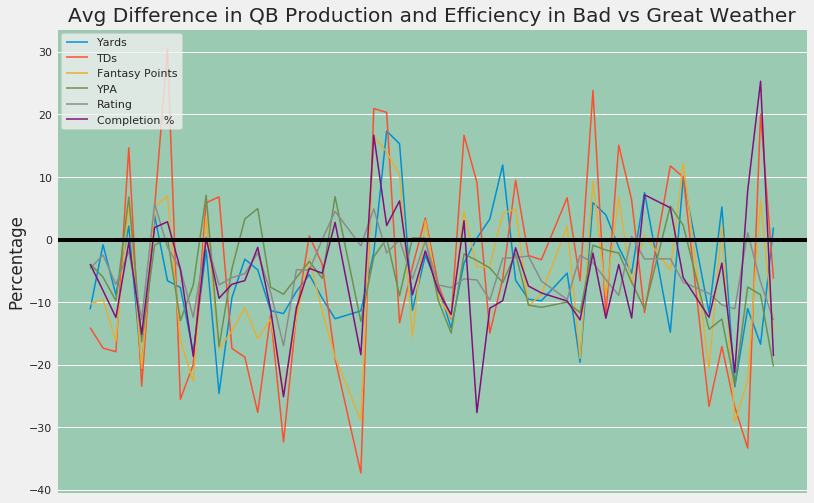

In [157]:
#remove 3 extreme outliers that skewed the graph silly:
subset = difference_df[difference_df.tds_percent_diff<31]

#Plot great weather vs bad weather avgs:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(subset[['yards_percent_diff', 'tds_percent_diff', 'fpts_percent_diff']], linewidth=1.5)
ax.plot(subset[['ypa_percent_diff', 'comp_percent_percent_diff', 'rating_percent_diff']], linewidth=1.5)
ax.patch.set_facecolor('#9bcab2')
#fig.patch.set_facecolor('#9bcab2')
ax.grid(color='white')
ax.xaxis.set_ticklabels([])
ax.axhline(y=0, xmin=0, xmax=1, color='black')
plt.ylabel('Percentage')
plt.title('Avg Difference in QB Production and Efficiency in Bad vs Great Weather')
plt.legend(['Yards', 'TDs', 'Fantasy Points', 'YPA', 'Rating', 'Completion %'])
ax.xaxis.grid(False)
plt.show()

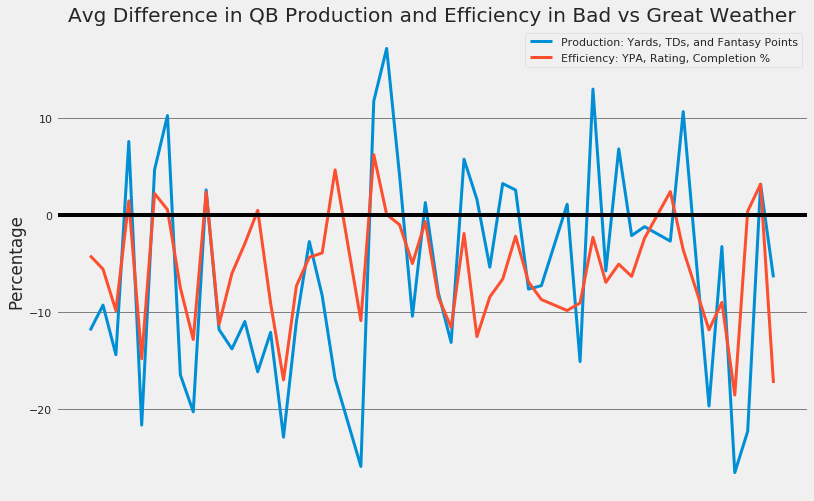

In [158]:
#Plot great weather vs bad weather avgs:
#remove 3 extreme outliers that skewed the graph silly:
subset = difference_df[difference_df.tds_percent_diff<31]

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(subset[['avg_production_diff', 'avg_efficiency_diff']], linewidth=3)
#ax.patch.set_facecolor('#9bcab2')
#fig.patch.set_facecolor('#9bcab2')
ax.grid(color='gray')
ax.xaxis.set_ticklabels([])
ax.axhline(y=0, xmin=0, xmax=1, color='black')
plt.ylabel('Percentage')
plt.title('Avg Difference in QB Production and Efficiency in Bad vs Great Weather')
plt.legend(['Production: Yards, TDs, and Fantasy Points', 'Efficiency: YPA, Rating, Completion %'])
ax.xaxis.grid(False)
plt.show()

In [0]:

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12,8))
ax.plot

Text(-1, 0.3, '     Drew Brees % Difference in Bad vs Great Weather')

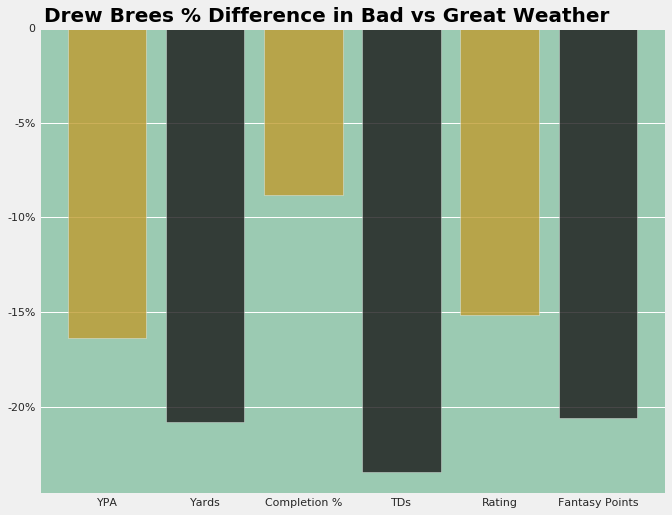

In [175]:
#Drew Brees Spotlight:

brees = difference_df[difference_df.name=='Brees, Drew']
x_cols = ['ypa_percent_diff', 'yards_percent_diff', 'comp_percent_diff', 'tds_percent_diff', 'rating_percent_diff', 'fpts_percent_diff']
x_labels = ['YPA', 'Yards', 'Completion %', 'TDs', 'Rating', 'Fantasy Points']
brees_y=[]
for col in x_cols:
  brees_y.append(brees[col].values[0])
  
#Plot  
colors = ['#bf9b30', '#191919', '#bf9b30', '#191919', '#bf9b30', '#191919']
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(x_labels, brees_y, color=colors, alpha=.8)
ax.patch.set_facecolor('#9bcab2')
#fig.patch.set_facecolor('#9bcab2')
ax.grid(color='white')
#ax.xaxis.set_label_position('top')
ax.set_yticklabels(['-25%', '-20%', '-15%', '-10%', '-5%', '0'])
ax.xaxis.grid(False)
ax.text(x=-1, y=0.3, s='     Drew Brees % Difference in Bad vs Great Weather', color='black', fontsize=20, fontweight='bold')  

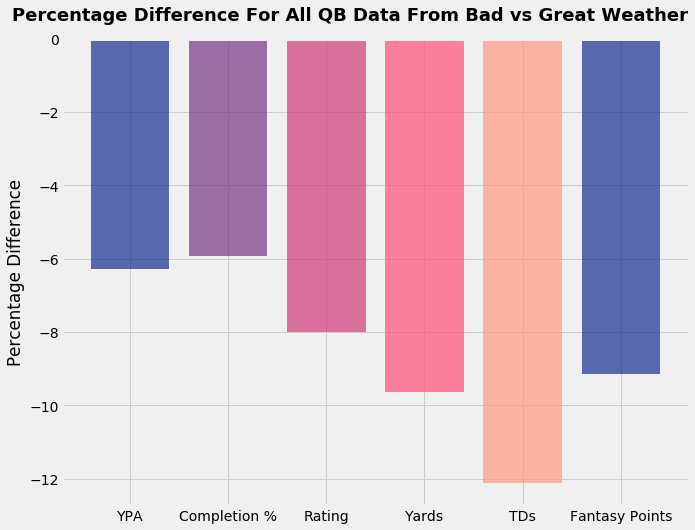

In [0]:
#Plot complete data from bad vs great:

diff_y = []
x_cols = ['ypa', 'comp_percent', 'rating', 'yards', 'tds', 'points']
x_labels = ['YPA', 'Completion %', 'Rating', 'Yards', 'TDs', 'Fantasy Points']

for col in x_cols:
  bad_agg = bad[col].mean()
  great_agg = great[col].mean()
  diff_y.append((bad_agg - great_agg)/great_agg*100)

colors = ['#192d92', '#763585', '#d23c77', '#ff4f79', '#ff997f', '#192d92']

#Plot  
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10, 8))
plt.bar(x_labels, diff_y, color=colors, alpha=.7)
ax.text(x=-1.2, y=.5, s='Percentage Difference For All QB Data From Bad vs Great Weather', color='black', fontsize=18, fontweight='bold')
plt.ylabel('Percentage Difference')
plt.show()
  

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning:

invalid value encountered in less



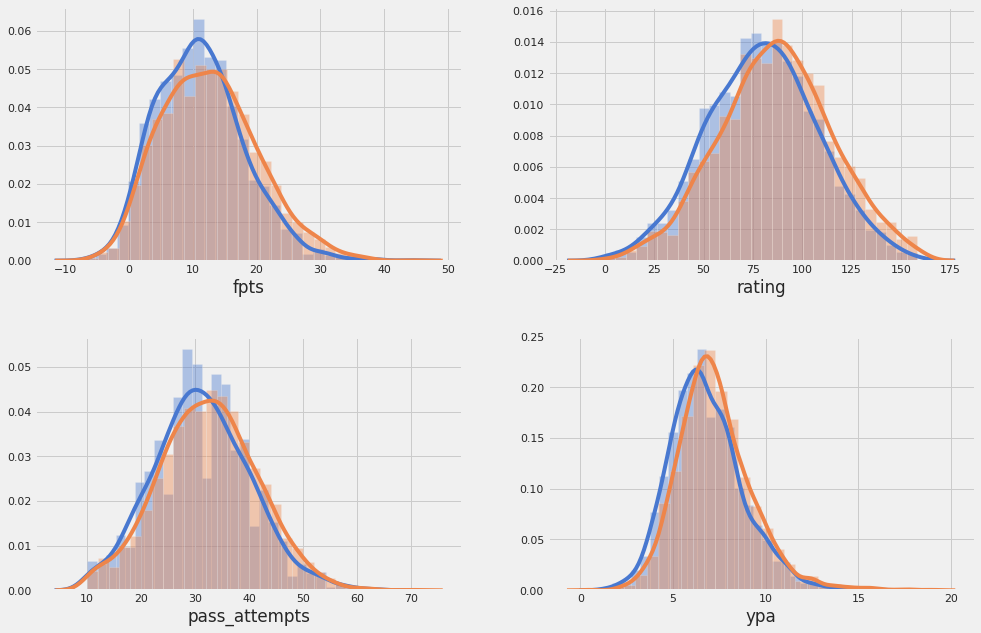

In [197]:
#Histogram of FPTs in great vs Bad- lus some otehr stats.. add title, legend
#fig, ax = plt.subplots(figsize=(12,8))
fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=2)
plt.subplots_adjust(hspace=.3)

sns.distplot(bad.fpts, bins =30, kde=True, ax=ax[0][0])
sns.distplot(great.fpts, bins =30, kde=True, ax=ax[0][0])
sns.distplot(bad.rating, bins=30, kde=True, ax=ax[0][1])
sns.distplot(great.rating, bins=30, kde=True, ax=ax[0][1])
sns.distplot(bad.pass_attempts, bins =30, kde=True, ax=ax[1][0])
sns.distplot(great.pass_attempts, bins =30, kde=True, ax=ax[1][0])
sns.distplot(bad.ypa, bins=30, kde=True, ax=ax[1][1])
sns.distplot(great.ypa, bins=30, kde=True, ax=ax[1][1])

plt.show()

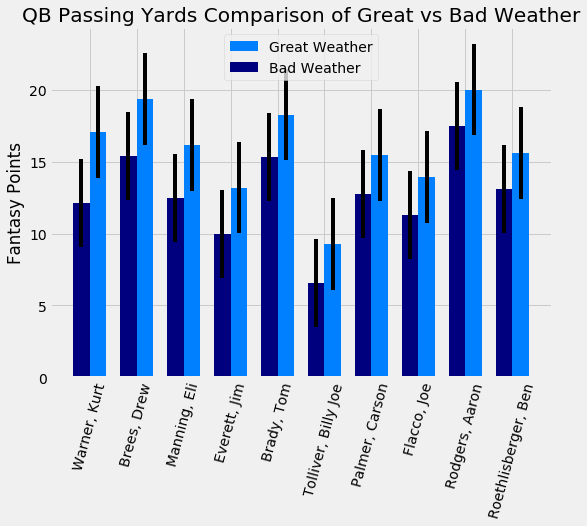

In [0]:
#sort by avg production diff to see players who play the worst in bad weather relative to good:

top_10_fpts_diff = difference_df.sort_values('fpts_diff').head(10)

#Plot the top 10:

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(8,6))

plt.bar(x=top_10_fpts_diff.name, height=top_10_fpts_diff.great_fpts_avg, yerr=top_10_fpts_diff.great_fpts_avg.std(), width=0.35, align='edge', color='#0080ff')
plt.bar(x=top_10_fpts_diff.name, height=top_10_fpts_diff.bad_fpts_avg, yerr=top_10_fpts_diff.bad_fpts_avg.std(), width=-0.35, align='edge', color='#00007f')


plt.xticks(rotation=75)
plt.title('QB Passing Yards Comparison of Great vs Bad Weather')
plt.ylabel('Fantasy Points')
plt.legend(labels=['Great Weather', 'Bad Weather'],loc=9)
plt.show()

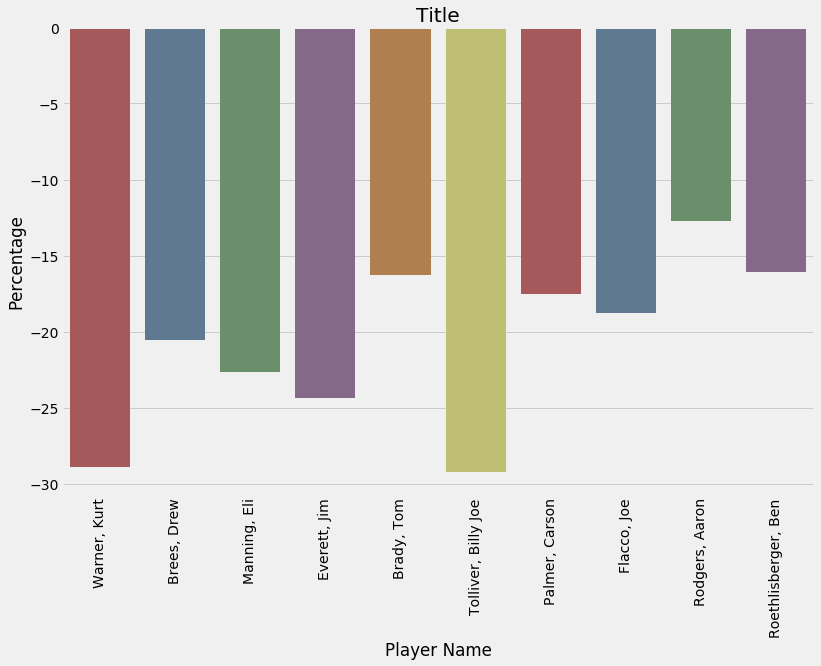

In [0]:

fig = plt.figure(figsize=(12,8))
ax = sns.barplot(y='fpts_percent_diff', x='name', data=top_10_fpts_diff, palette=sns.color_palette("Set1", n_colors=6, desat=.5))

#plt.bar(x=top_10['name'], height=top_10['avg_production_diff'], width=0.25, align='edge', color='#ff7b7b')
#plt.bar(x=top_10['name'], height=top_10['avg_efficiency_diff'], width=-0.25, align='center', color='yellow')
#plt.bar(x=top_10['name'], height=top_10['avg_turnovers_diff'], width=0.25, align='edge', color='blue')       

plt.xticks(rotation=90)
plt.title('Title')
plt.ylabel('Percentage')
plt.xlabel('Player Name')

#plt.legend(labels=['Production', 'Efficiency'],loc=2)
plt.show()

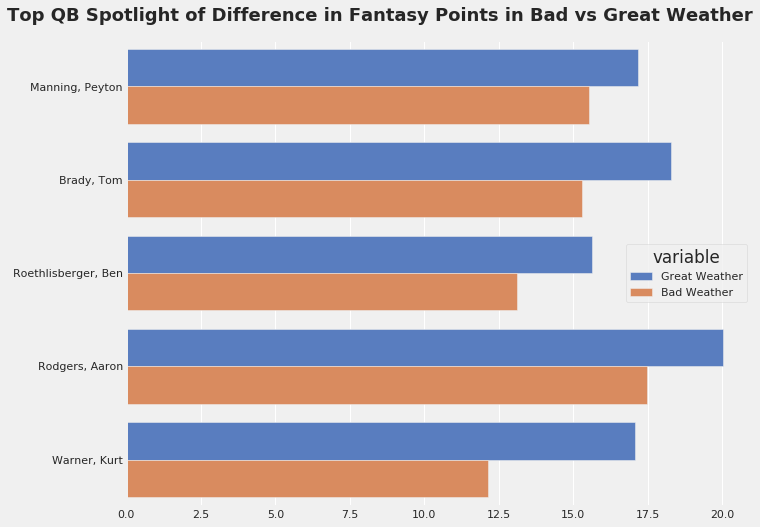

In [184]:
#Spotlight on Rodgers/Brady/Ben/Brees/Rivers- wantto compare a few of the best who 
#play in bad weather frequently (brady, rodgers, ben) vs a few  who mostly play 
#in a dome or good weather city (peyton manning, warner)

players = ['Rodgers, Aaron', 'Brady, Tom', 'Roethlisberger, Ben', 'Manning, Peyton', 'Warner, Kurt']
subset = difference_df[difference_df.name.isin(players)][['name', 'great_fpts_avg', 'bad_fpts_avg']]
subset=subset.rename(columns={'great_fpts_avg': 'Great Weather', 'bad_fpts_avg': 'Bad Weather'})
tidy = subset.melt(id_vars='name')

#plot
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_palette(palette='muted', n_colors=5)
sns.barplot(y='name', x='value', orient='h', hue='variable', data=tidy, ax=ax)
ax.text(x=-4, y=-.7, s='Top QB Spotlight of Difference in Fantasy Points in Bad vs Great Weather', fontsize=18, fontweight='bold')
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.set_xlabel('Fantasy Points per Game')
ax.grid(color='white')
ax.yaxis.grid(False)
plt.show()

In [0]:
for i in difference_df.index:
  if difference_df.at[i, 'avg_turnovers_diff'] < 0:
    difference_df.at[i, 'adjusted_turnovers'] = -difference_df.at[i, 'avg_turnovers_diff']
  else:
    difference_df.at[i, 'adjusted_turnovers'] = 0

In [187]:
configure_plotly_browser_state()
px.scatter(difference_df, x="avg_efficiency_diff", y="fpts_diff", size="adjusted_turnovers", size_max=30, hover_name="name", color='name')

In [0]:
#statistical tests:
ttest_cols = ['yards', 'tds', 'fpts', 'ypa', 'rating', 'comp_percent', 'sacks', 'ints', 'fumbles']

great_bad_ttest_results = []

#bad weather vs great weather:

for col in ttest_cols:
  t, p = stats.ttest_ind(great[col], bad[col], nan_policy='omit')
  mean_great = round(great[col].mean(), 2)
  mean_bad = round(bad[col].mean(), 2)
  diff = round((mean_great - mean_bad), 2)
  great_bad_ttest_results.append([col, 't-stat: ' + str(round(t, 5)), 
                                  'p-value ' +str(p), 'mean_great: ' + str(mean_great), 
                                  'mean_bad :' + str(mean_bad), 'difference: ' + str(diff)])


#ttest for wind:

winds = [5, 10, 15, 20]

wind_ttest_results = []
for wind in winds:
  for col in ttest_cols:
    t, p = stats.ttest_ind(df[df.wind <= wind][col], df[df.wind > wind][col], nan_policy='omit')
    mean_under = round(df[df.wind <= wind][col].mean(), 2)
    mean_over = round(df[df.wind > wind][col].mean(), 2)
    diff = round((mean_under - mean_over), 2)
    wind_ttest_results.append(['stat: ' + str(col), 'avg wind: ' + str(wind), 't-stat: ' + str(round(t, 5)), 
                               'p-value: ' + str(p), 'mean under: ' + str(mean_under), 
                               'mean over: ' + str(mean_over), 'difference in means: ' + str(diff)])
    
#ttest for :

precip_results = []
precip_cats = list(df.precipitation.value_counts().index)
for cat in precip_cats:
  for col in ttest_cols:
    t, p = stats.ttest_ind(df[df.precipitation == cat][col], df[~(df.precipitation == cat)][col], nan_policy='omit')
    mean_cat = round(df[df.precipitation == cat][col].mean(), 2)
    mean_other = round(df[~(df.precipitation == cat)][col].mean(), 2)
    diff = round((mean_cat - mean_other), 2)
    precip_results.append(['precipitation: ' + str(cat), 'stat: ' + str(col), 't-stat: ' + str(round(t, 5)), 
                               'p-value: ' + str(p), 'mean for category: ' + str(mean_cat), 
                               'mean for the rest: ' + str(mean_other), 'difference in means: ' + str(diff)])
    



In [0]:
'''#ttest for temp:
temp_condition = ['(df.temp < 20)', '(df.temp > 20) & (df.temp < 50)', '(df.temp > 50) & (df.temp < 80)', '(df.temp > 80)']

temp_results = []
for condition in temp_condition:
  for col in ttest_cols:
    mean_condition = df[condition][col].mean()
    temp_results.append(condition + 'mean: ' + str(mean_condition))'''